# Sales forecasting Store Sales

### Test challenge
##### Goal: Explore data and predict a month of sales for . 

This notebook mainly focuses on the Time Series Analysis, a homework for lesson of DL data science training. We then disscuss advantages and drawbacks of modeling with Seasonal ARIMA and Prophet.

As it usually goes, we start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis. 

Also, alternatively to forecasting with Prophet, we use one of the most robust and sophisticated algorythm Extreme Gradient Boosting for regression.

finnaly we try LSTM by Keras for forecasting result, and try to find out advance and drawback. 

!["shop"](rossmann_banner2.png "shop")

---

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
# %matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import date
# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [3]:
# importing train data to learn
train = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

print(train.shape)
# additional store data
# store = pd.read_csv("~/Documents/rossmann_TSA_forecasts/store.csv", 
#                     low_memory = False)
# time series as indexes
train.index

(1580, 11)


DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='YearMonth', length=1580, freq=None)

## Exploratory Data Analysis 

In this first section we go through the train data of result data, handle missing values and create new features for further analysis.

In [4]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(12).append(train.tail(12))

In total:  (1580, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2014-01-01,East,2111256114,33,pack2,4340.67530,14091.45400,2014,1,1,2,1
2014-02-01,East,2111256114,33,pack2,4580.52730,19698.48400,2014,2,1,6,1
2014-03-01,East,2111256114,33,pack2,2007.39200,2771.15140,2014,3,1,1,1
2014-04-01,East,2111256114,33,pack2,1651.48010,3096.13310,2014,4,2,3,1
2014-05-01,East,2111256114,33,pack2,6113.11910,26282.81100,2014,5,2,4,1
2014-06-01,East,2111256114,33,pack2,896.07300,2914.21020,2014,6,2,2,1
2014-07-01,East,2111256114,33,pack2,2039.29000,2437.58060,2014,7,3,0,0
2014-08-01,East,2111256114,33,pack2,3485.64890,1089.57250,2014,8,3,0,0
2014-09-01,East,2111256114,33,pack2,3934.42410,3672.25340,2014,9,3,3,1


Short description:
- SalesQty: the turnover for any given day (target variable).
- YearMonth: the Date of shipment and sales.
- Region: the area of store location
- ItemCode: an indicator product code each sales item.
- BrandCode: indicates brand name which numbered.
- Package: indicates type of packages for sales item. 
- ShiQty: indicates quantities of shipment
- SalesQty: indicates quantities of sales
- Year: indicates year of sales
- Quarter: indicates quarter of year
- HolidayDay: indicates number of day during month

## Analysis of Sales

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


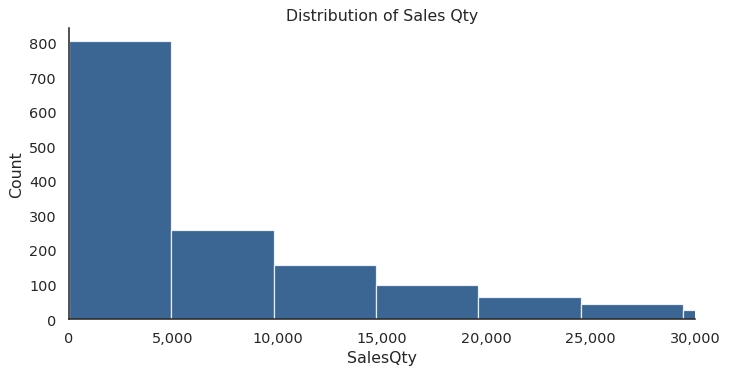

In [5]:
# set graphical parameters
# % matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 90
sns.set_context('notebook', font_scale=1.05)
sns.set_style('white')

pal = ['#066b2b', '#0a3e78', '#ae1626','#444745','#55a15a', '#5588a1', 'indianred']

fig, ax = plt.subplots(figsize = (8, 4))

ax.hist(train['SalesQty'], alpha = .8, bins=60, color = pal[1])
ax.set_title('Distribution of Sales Qty')
ax.set_ylabel('Count', fontname = 'Arial')
ax.set_xlabel('SalesQty', fontname = 'Arial')
ax.set_xlim(0, 30000)

x_vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}'.format(x) for x in x_vals], fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

* check on the sales of zero on holiday for each brand, is there any finding

In [6]:
train[train['SalesQty']==0].groupby(['HolidayDay','BrandCode'])['SalesQty'].aggregate('count').unstack()


BrandCode,33,34,53,74
HolidayDay,,,,
0,24.0,3.0,4.0,2.0
1,8.0,2.0,2.0,NaN
2,6.0,1.0,1.0,NaN
3,7.0,5.0,NaN,NaN
4,2.0,1.0,1.0,NaN
5,3.0,NaN,NaN,NaN
7,6.0,2.0,2.0,NaN
8,NaN,1.0,1.0,NaN


### ECDF: empirical cumulative distribution function

To get the first impression about continious variables in the data we can plot ECDF. from here we can see the shipment and sales keeping a very good balance. 

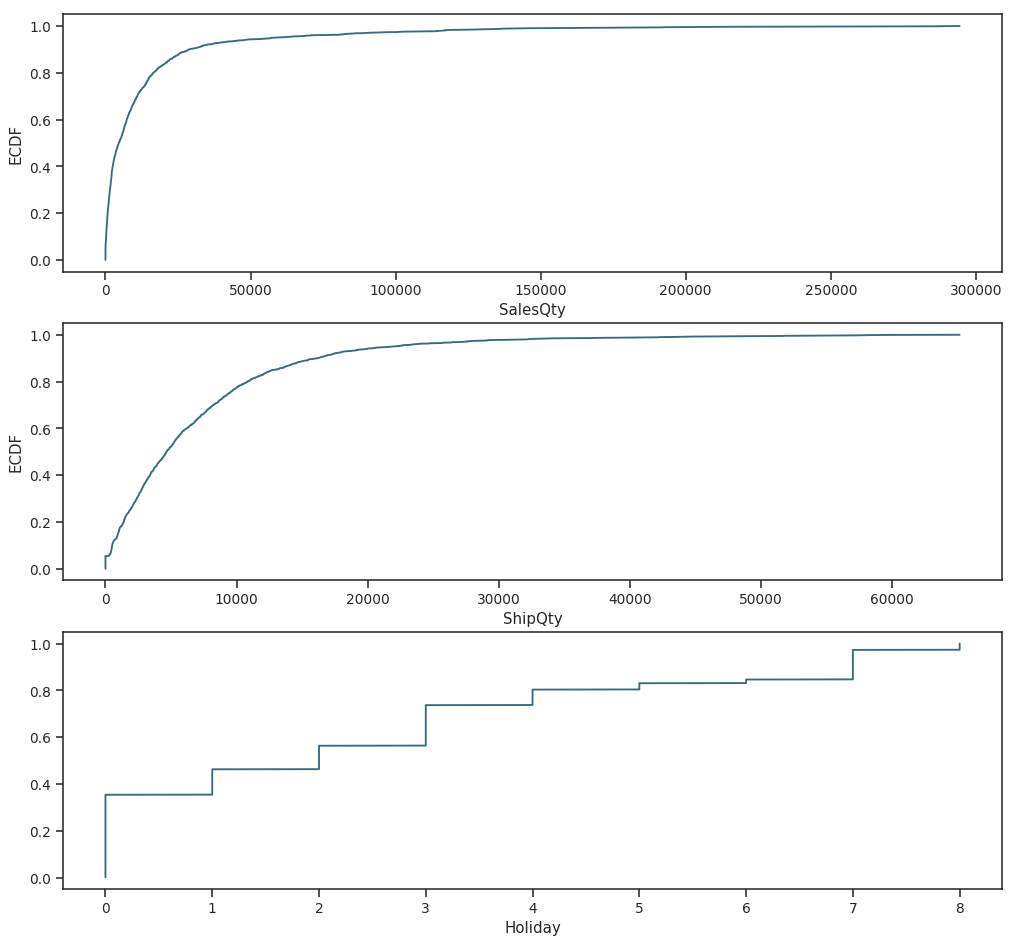

In [7]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

plt.subplot(311)
cdf = ECDF(train['SalesQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('SalesQty'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['ShipQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('ShipQty');plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['HolidayDay'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Holiday');

About 20% of data has zero amount of sales,  30% of holiday are 3 days, shipment is far less than sales qty. 

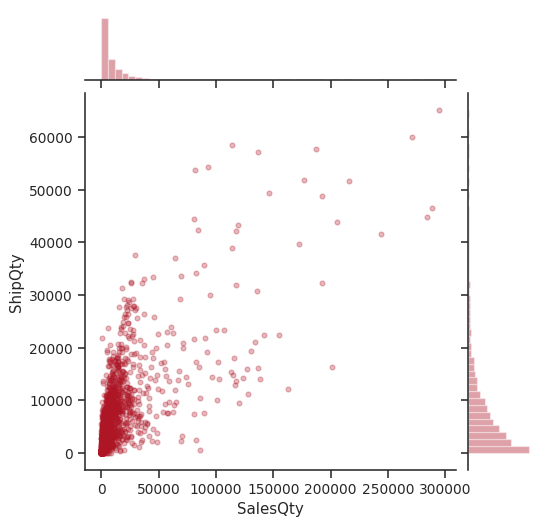

In [8]:
g= sns.jointplot(train['SalesQty'],train['ShipQty'], color=pal[2], alpha= 0.3, joint_kws={'s':15})


## Impact of Holiday on Sales

Text(0.5, 1.0, 'Sales of Holiday Month')

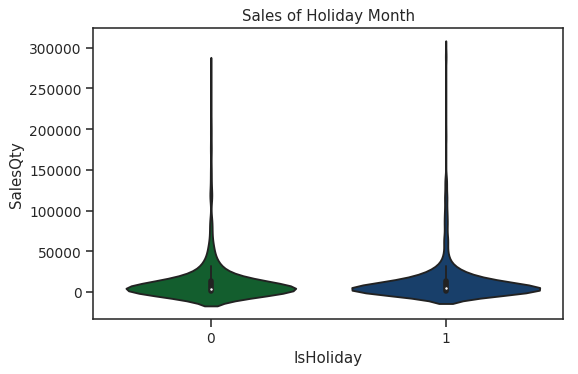

In [9]:
fig, ax = plt.subplots()
ax = sns.violinplot(x= 'IsHoliday', y = 'SalesQty', data=train, palette=pal)
ax.set_title('Sales of Holiday Month')


- if only take look on the distrubution of sales, there is no big difference of sales quatities. 

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


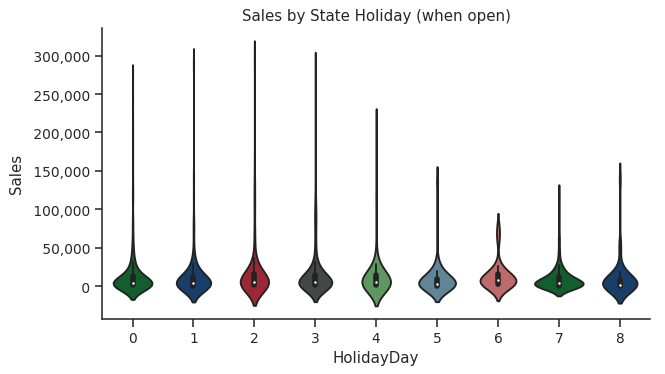

In [10]:
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.violinplot(x = 'HolidayDay', y = 'SalesQty', data = train, palette = pal)
ax.set_title('Sales by State Holiday (when open)', fontname = 'Arial')
ax.set_ylabel('Sales', fontname = 'Arial')


x_vals = ax.get_xticks()
ax.set_xticks(x_vals)

y_vals = ax.get_yticks()
ax.set_yticklabels([' {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

sns.despine();

- seems there is no difference of sales amount distribution

### Missing values or some accidents 
#### on working day of zero sales stores

In [11]:
# Sales is zero during working day
zero_workingDaySales=train[(train.SalesQty == 0) & (train.HolidayDay==0) ]
print("in total:" ,zero_workingDaySales.shape)
zero_workingDaySales.head(10)


in total: (33, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2016-08-01,East,2992101565,34,pack3,364.47937,0.0,2016,8,3,0,0
2016-07-01,East,5203395462,33,pack2,0.00000,0.0,2016,7,3,0,0
2016-08-01,East,5203395462,33,pack2,0.00000,0.0,2016,8,3,0,0
2016-11-01,East,5203395462,33,pack2,908.05933,0.0,2016,11,4,0,0
2017-11-01,East,5203395462,33,pack2,479.73328,0.0,2017,11,4,0,0
2015-11-01,Inner,3331397693,74,pack3,3672.21680,0.0,2015,11,4,0,0
2017-09-01,Inner,3331397693,74,pack3,0.00000,0.0,2017,9,3,0,0
2015-11-01,Inner,6288617494,33,pack4,0.00000,0.0,2015,11,4,0,0
2015-12-01,Inner,6288617494,33,pack4,0.00000,0.0,2015,12,4,0,0


,Year,Month,ShipQty
count,33.000000,33.000000,33.000000
mean,2015.939394,9.484848,713.833837
std,0.863836,1.970425,1100.124521
min,2014.000000,6.000000,0.000000
25%,2015.000000,8.000000,0.000000
50%,2016.000000,11.000000,364.479370
75%,2017.000000,11.000000,908.059330
max,2017.000000,12.000000,4083.933100


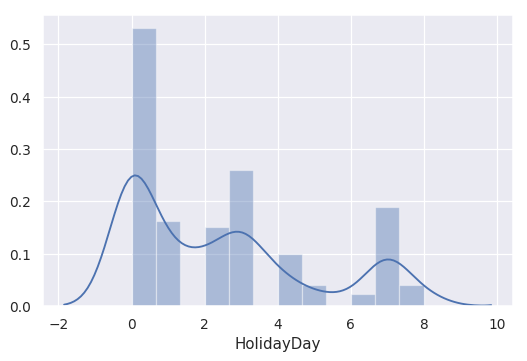

In [12]:
sns.set(style="darkgrid")
sns.distplot(train.HolidayDay)
train[(train.SalesQty==0)&(train.HolidayDay==0)].loc[:,['Year','Month','ShipQty']].describe()

There're 33 stores with zero sales in the data __during working day__. It is about 0.2% of the total amount of observations. there are some facts involved, maybe is the manifestations. To avoid any biased , we want see the distribution of the data.  


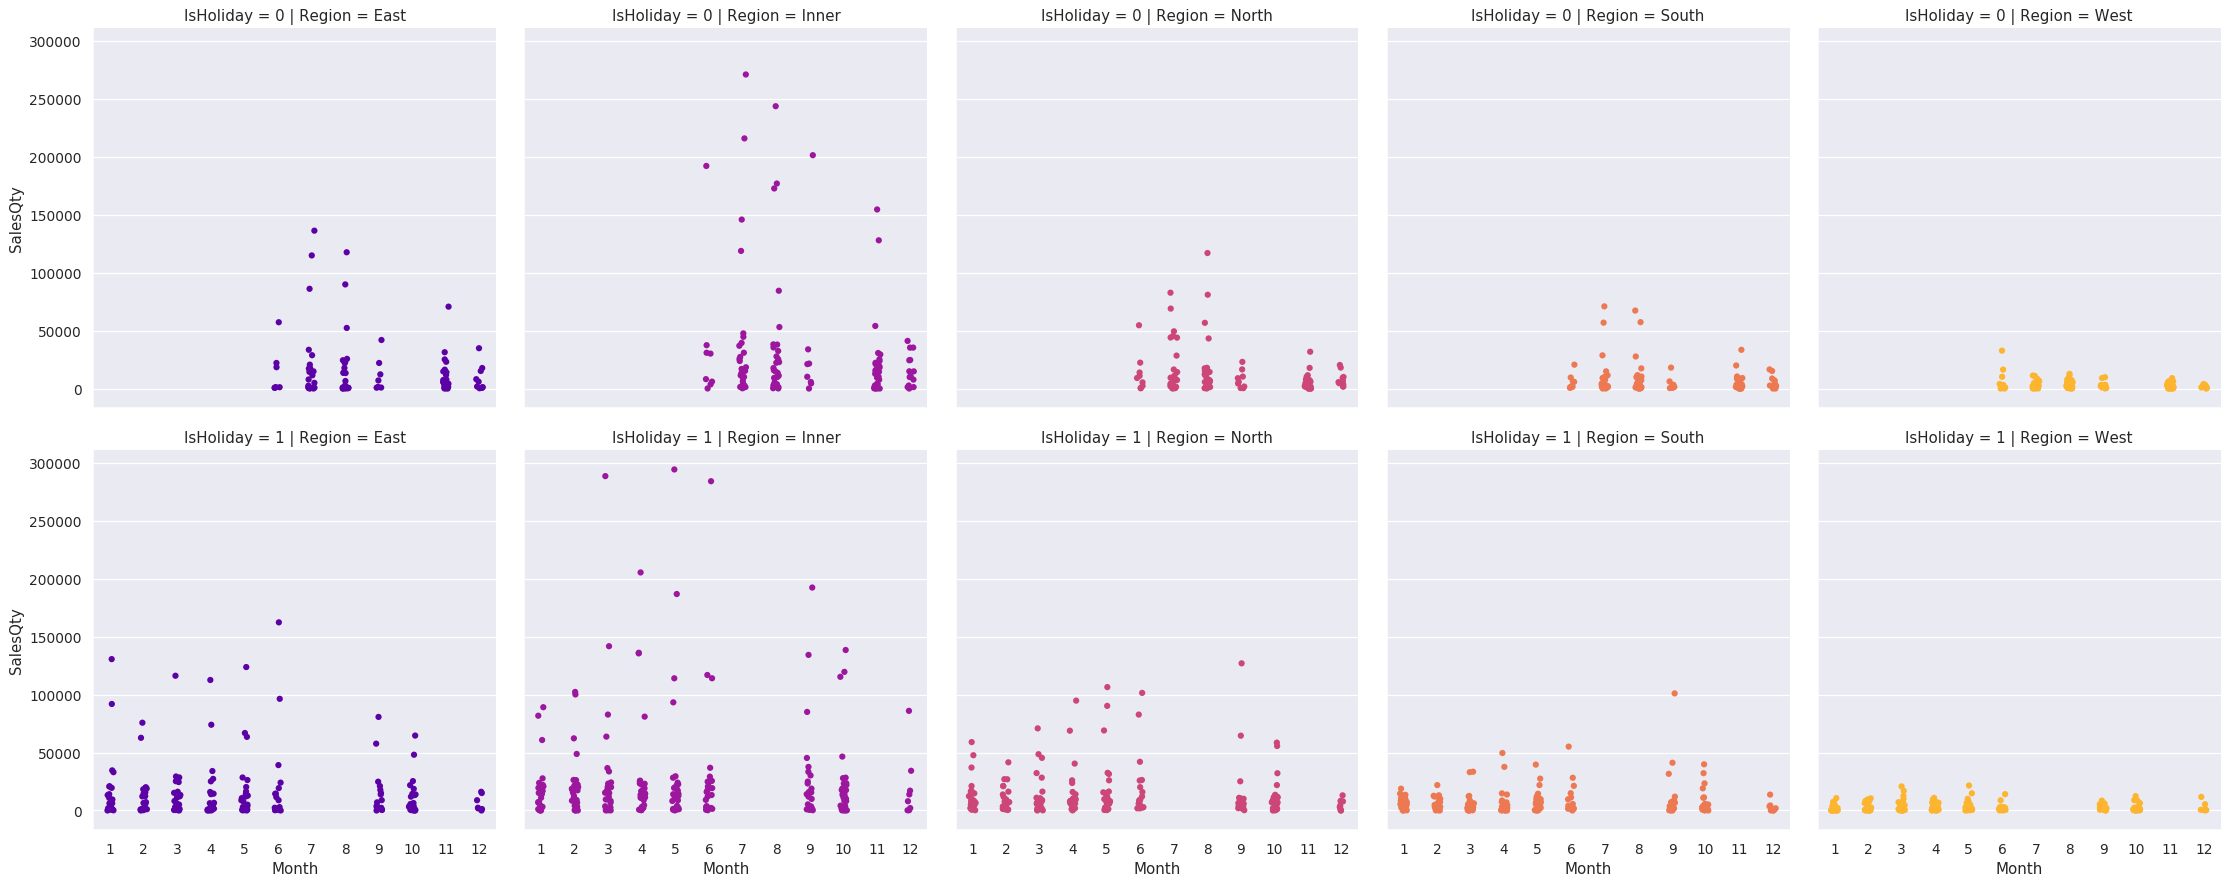

In [13]:
# sales trends
c = '#386B7F'
sns.catplot(data = train, x = 'Month', y = "SalesQty", 
               col = 'Region', # per region type in cols
               palette = 'plasma',
               hue = 'Region',
               row = 'IsHoliday', # per promo in the store in rows
               color = c) 

##### - very interesting finding, before holiday and after holiday, very easy to see the sales got increace

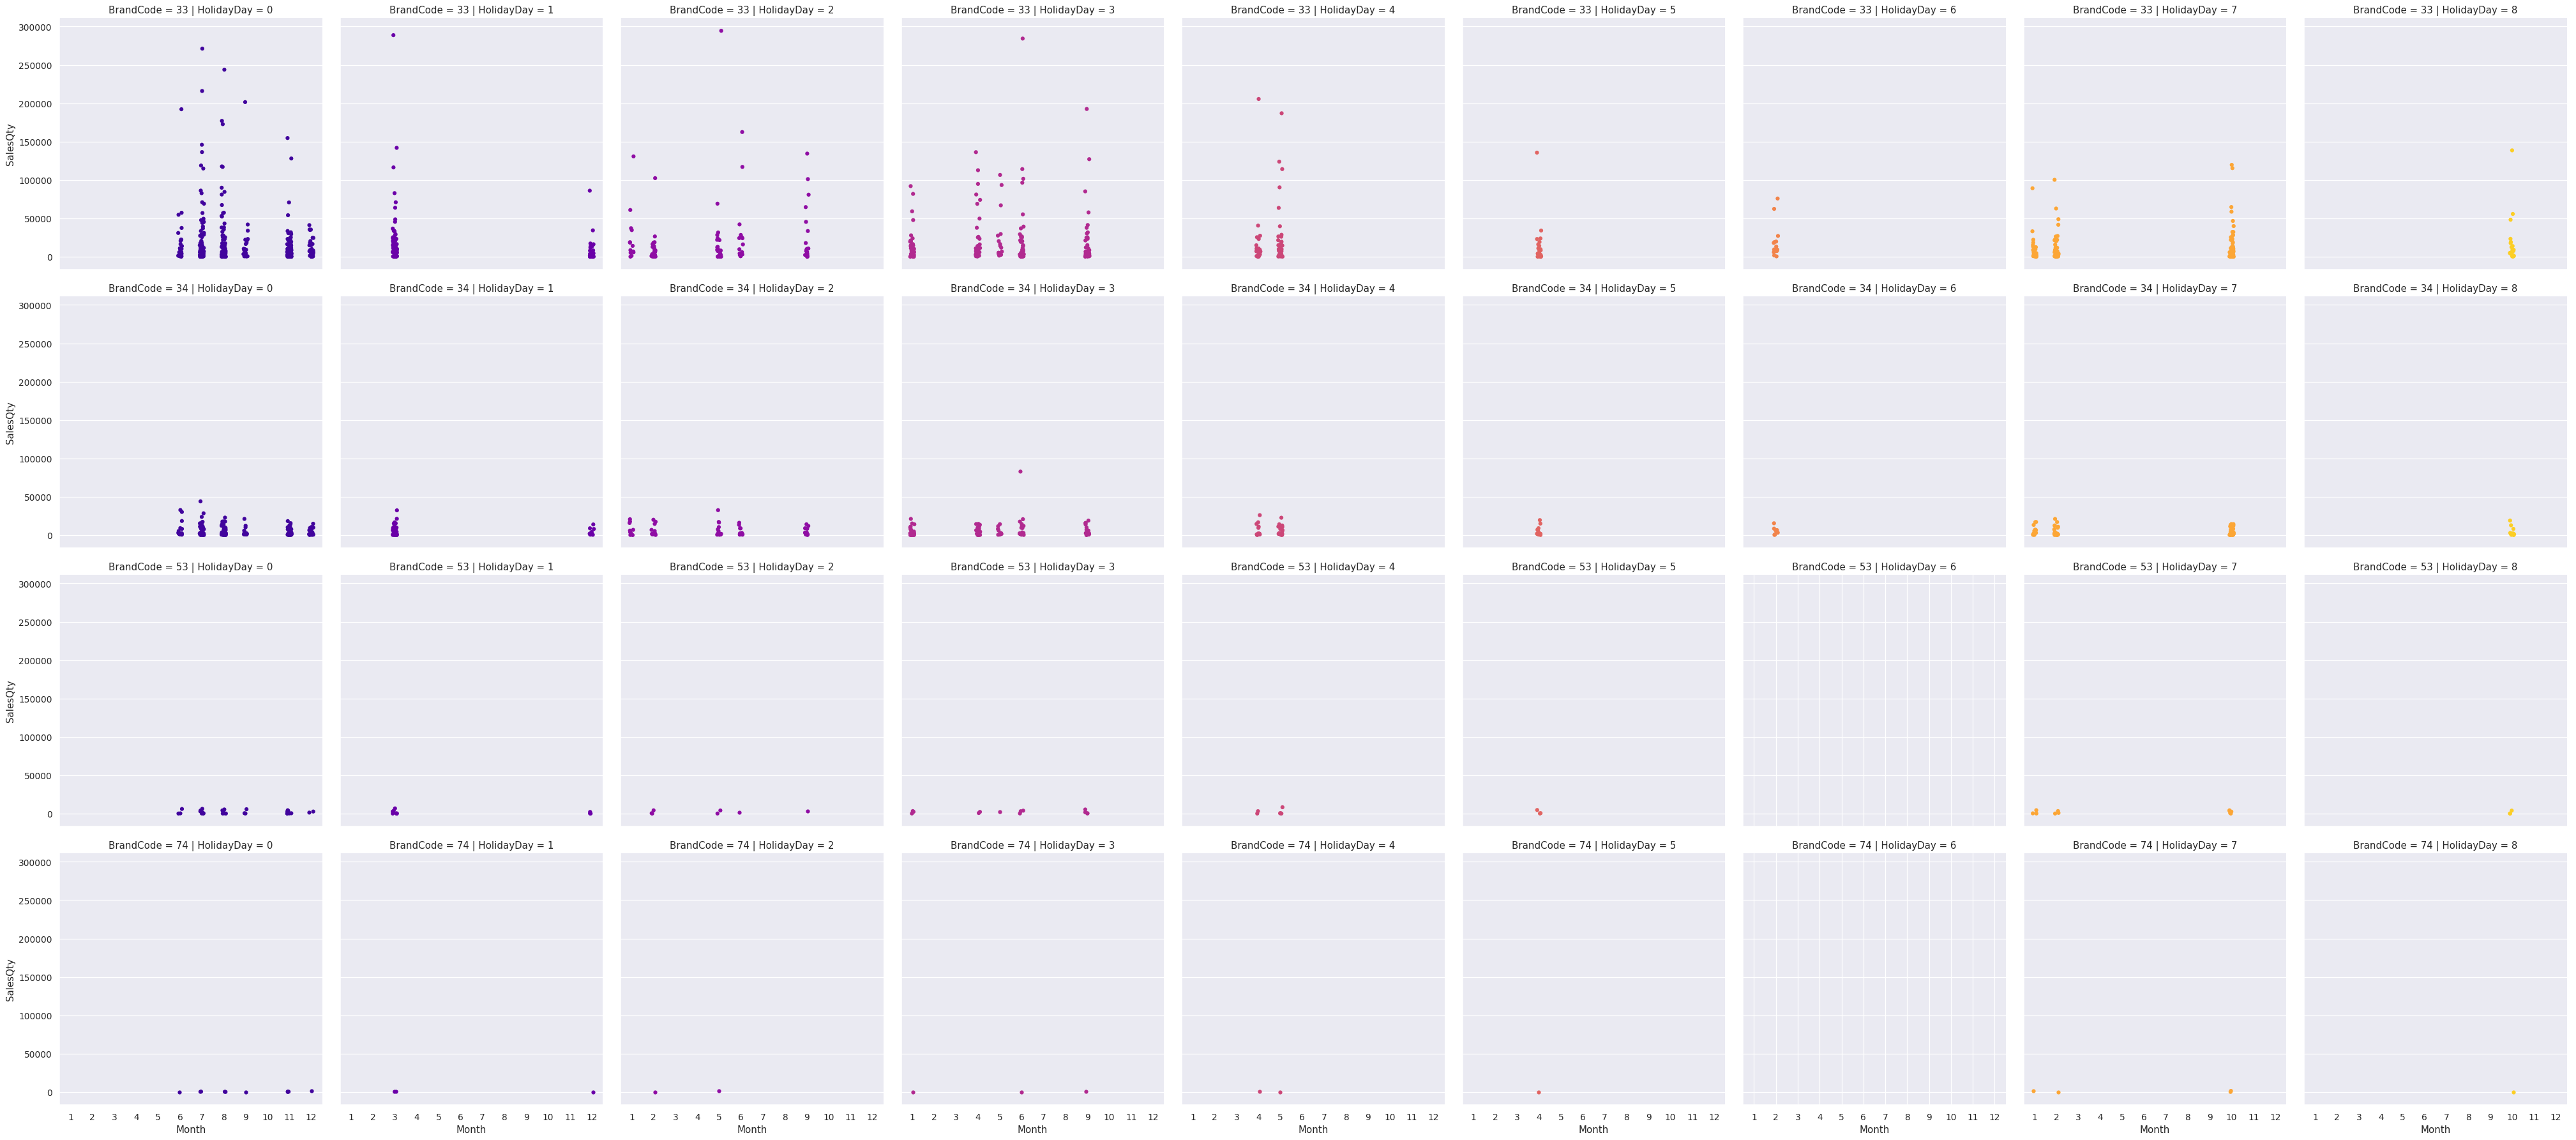

In [14]:
# sale per BrandCode trends
sns.catplot(data = train, x = 'Month', y = "SalesQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'HolidayDay',
               row = 'BrandCode',
              
               color = c) 

the correlation of SalesQty & Days of Holiday　&　Brand are show that, those three feature are impact sales very much. `BrandCode = 33` is very popular. 

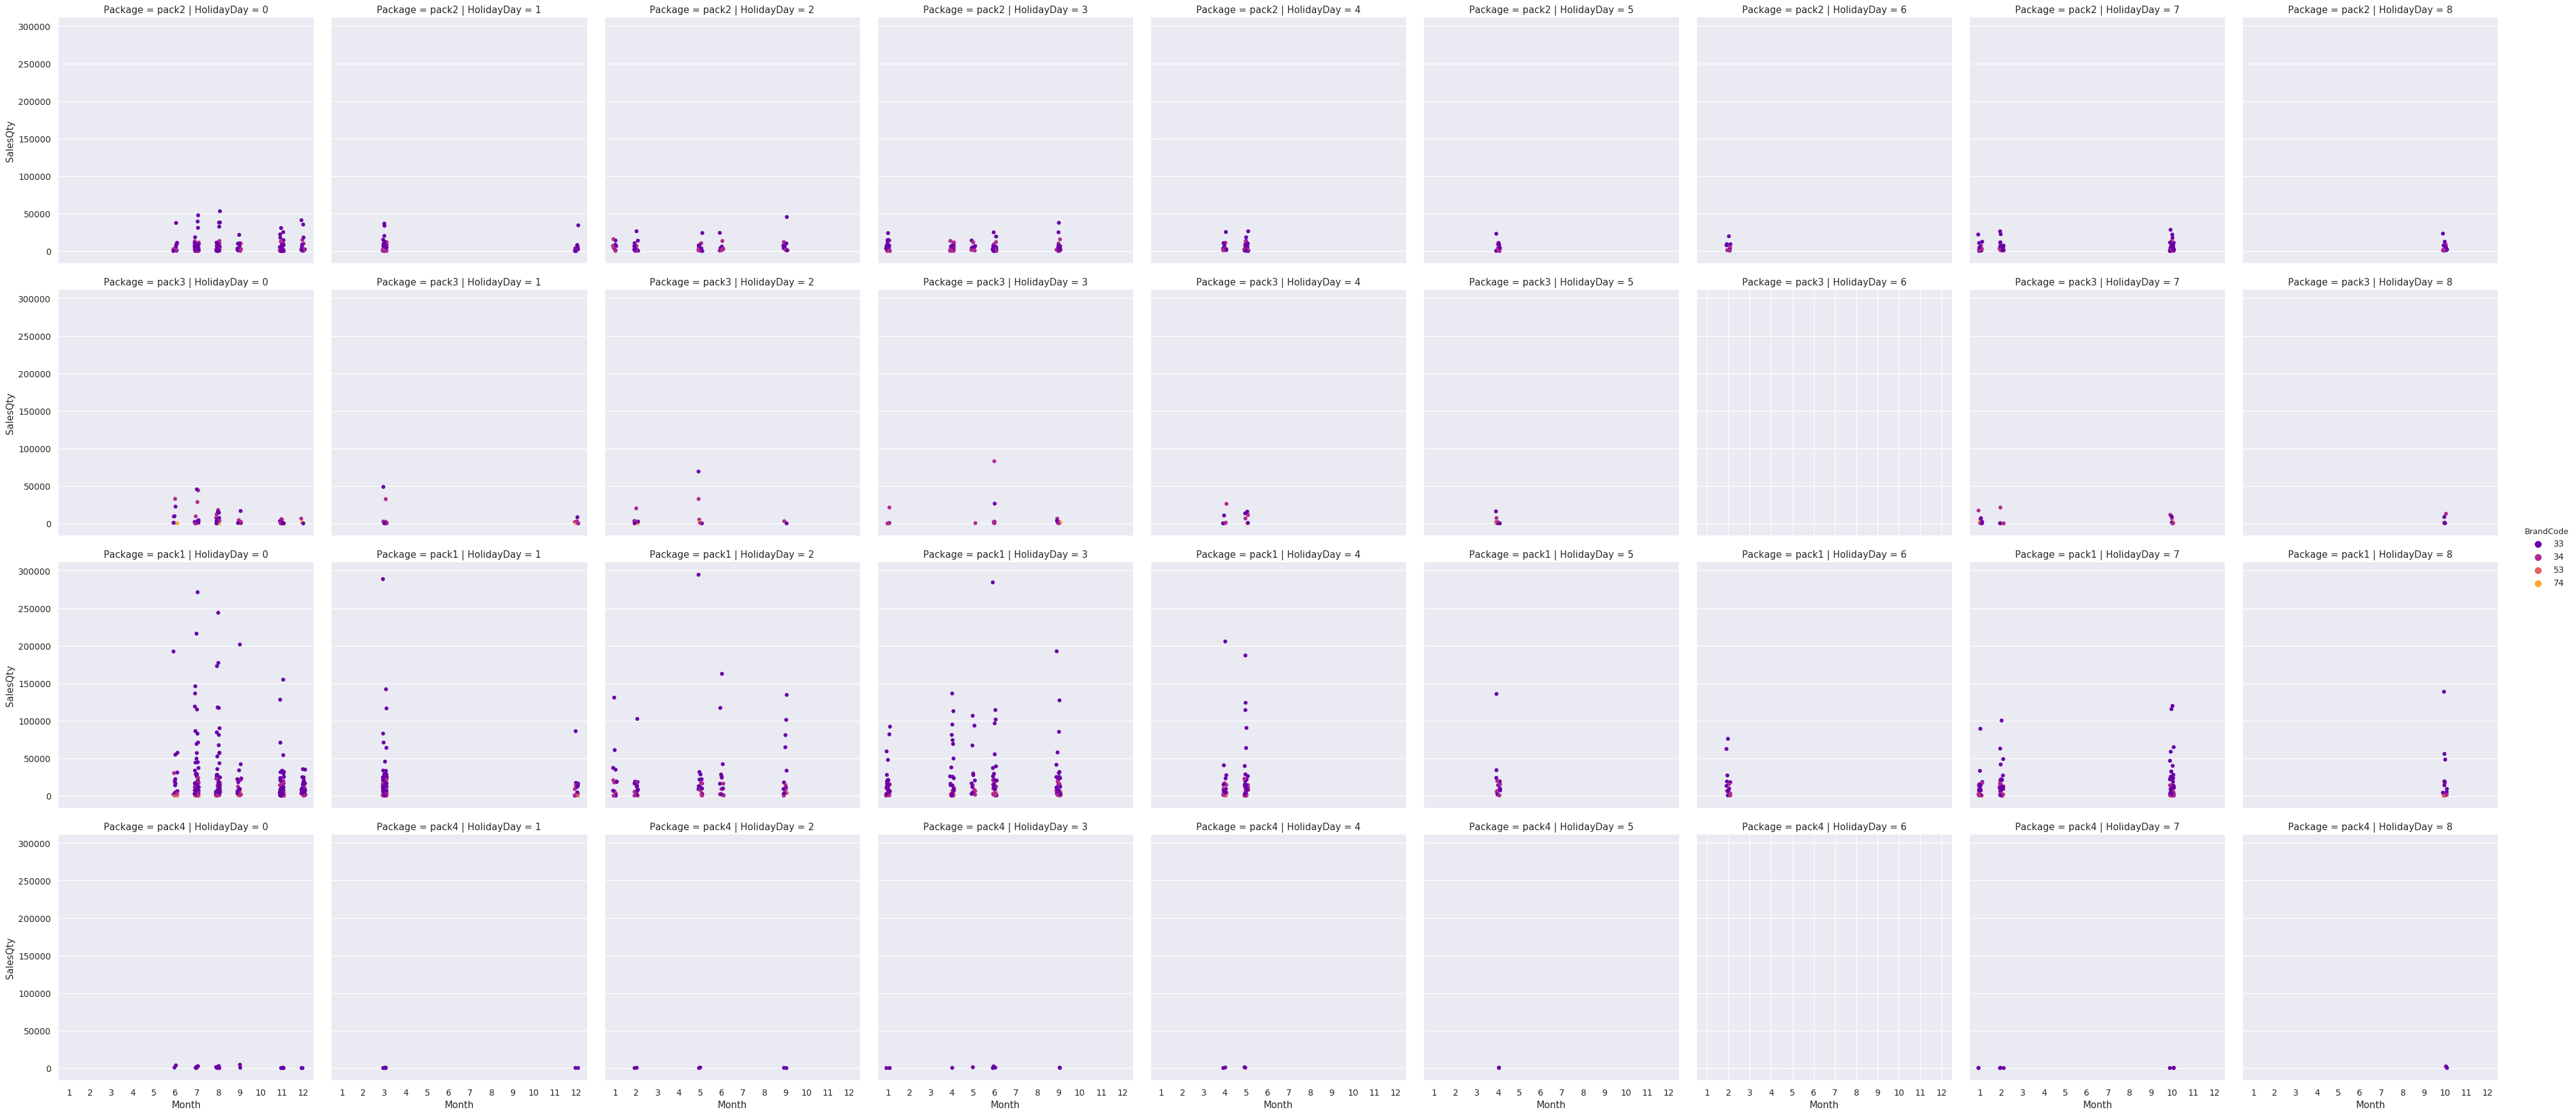

In [15]:
# sale per sales trends
sns.catplot(data = train, x = 'Month', y = "SalesQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'Package',
              
               color = c) 

We see that package is also correlative to sales. `package 1` is very positive correlative to each brand

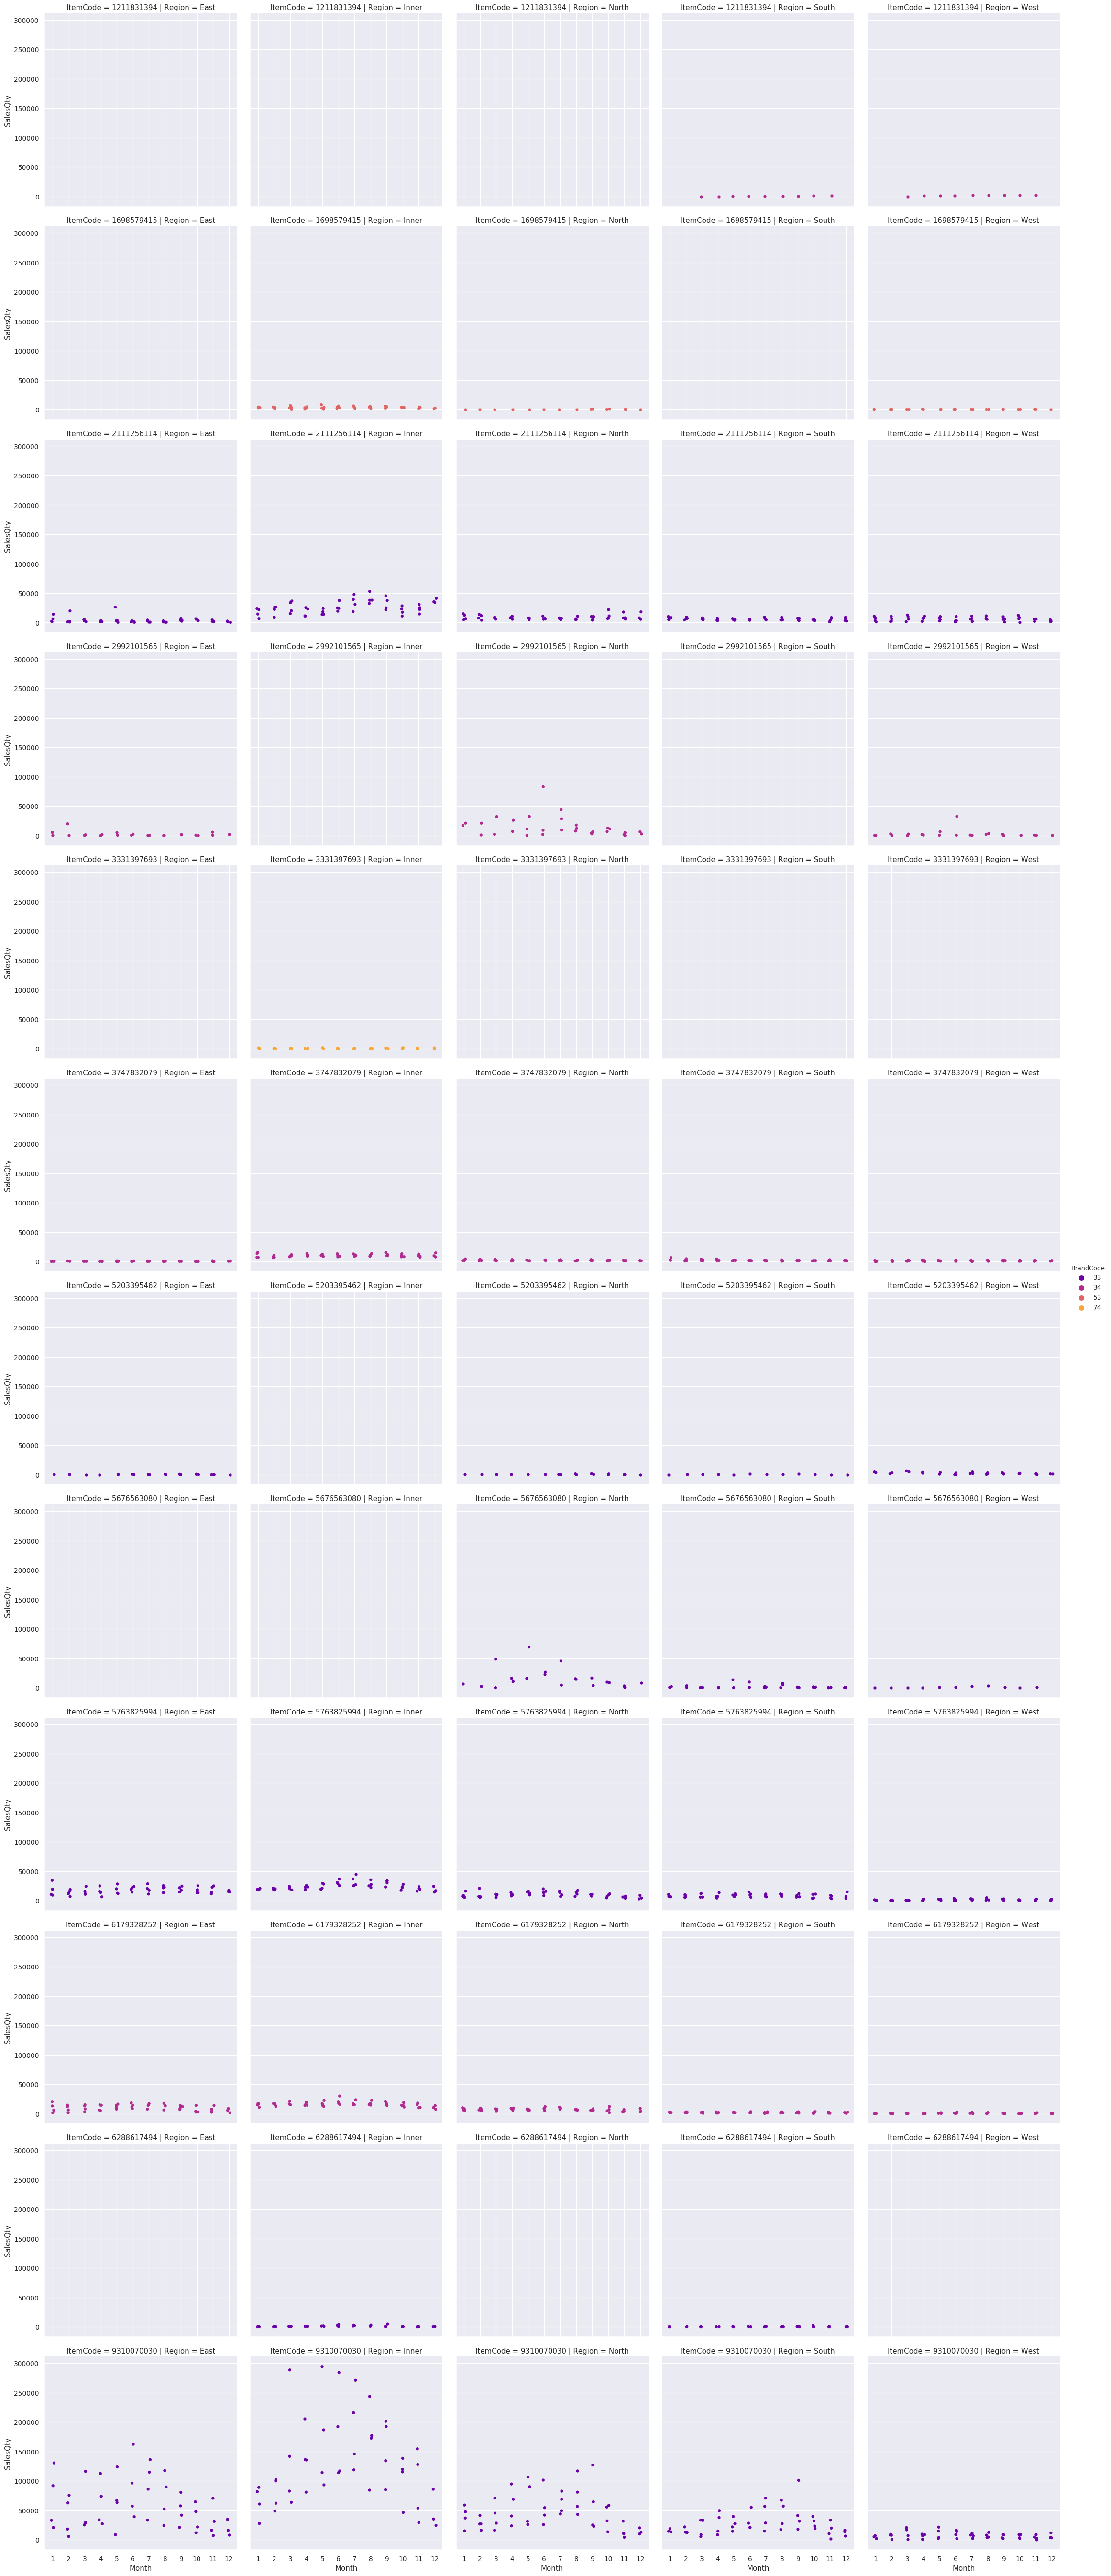

In [16]:
# sale per customer trends
sns.catplot(data = train, x = 'Month', y = "SalesQty", 
               col = 'Region', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'ItemCode',
              
               color = c) 

- interesting finding, the `Item code` is very  big defference of `sales` in each ereas. like eg. in east area, `ItemCode= 1698579415, ItemCode = 1211831394` got no sales. 

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

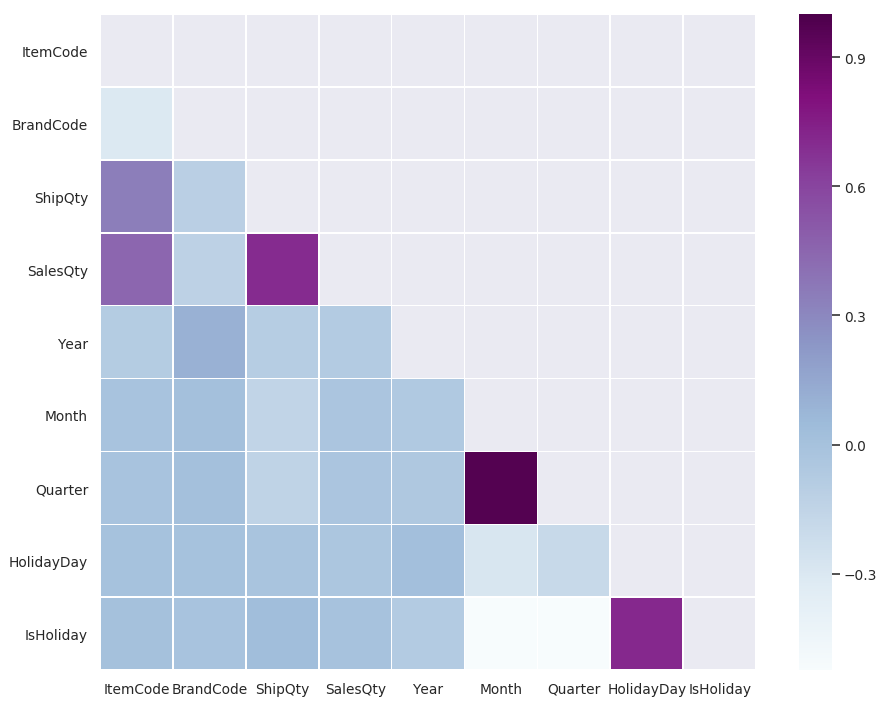

In [17]:
# Compute the correlation matrix 

corr_all = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the `ItemCode` and  `SalesQty` .  We can also observe a positive correlation between the `shipQty`  and  `ItemCode`. 


There are several things here:
- In case of holiday,  `Sales` tend to peak(!). Though we should note that `Holiday` on different month is affecting Sales. So it is mainly data from `Holiday` . and if holiday day is `three` days, the sales keep close to peak (!).
- On the contrary, stores that during working day tend to make most of the `Sales` on `east` and `inner` duing month of `6,7,8,9,11,12` .  The same trend follow the stores which have different `package` specially for `package1` and `package2`
- `Itemcode` alone `9310070030` seem to be correlated to any significant change in the `Sales` amount. This can be also prooved by the blue pale area on the heatmap above which is `ItemCode` is very positive correlation with the `shipQty` and `SalesQty`

---

## Conclusion of EDA

- The most selling and crowded `ItemCode` is `9310070030`.


- The best "Sale per Region"  is `east` and `inner`. We could also assume that the stores of this types are situated in the central city or tie one areas, so that customers buying behavior is not that sensitive of holiday. not only small volumns or big volumns. 


- Low `SalesQty` amount for `Region` indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.


- Customers tends to buy more on `Month` of `Holiday`, when there is no holiday month at all the sales of that month close to `zero`.





## Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem? 

- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.


- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for China Spring festival holidays, which we will see in this dataset.

<div class = "alert alert-block alert-info"> We build a time series analysis on region instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset. </div>

### Seasonality

We take five region from regions to represent their group:
- region number 1 for `Region` East
- region number 2 for `Region` Inner, 
- region number 3 for `Region` West 
- region number 4 for `Region` North.
- region number 5 for `StoreType` South. 


It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

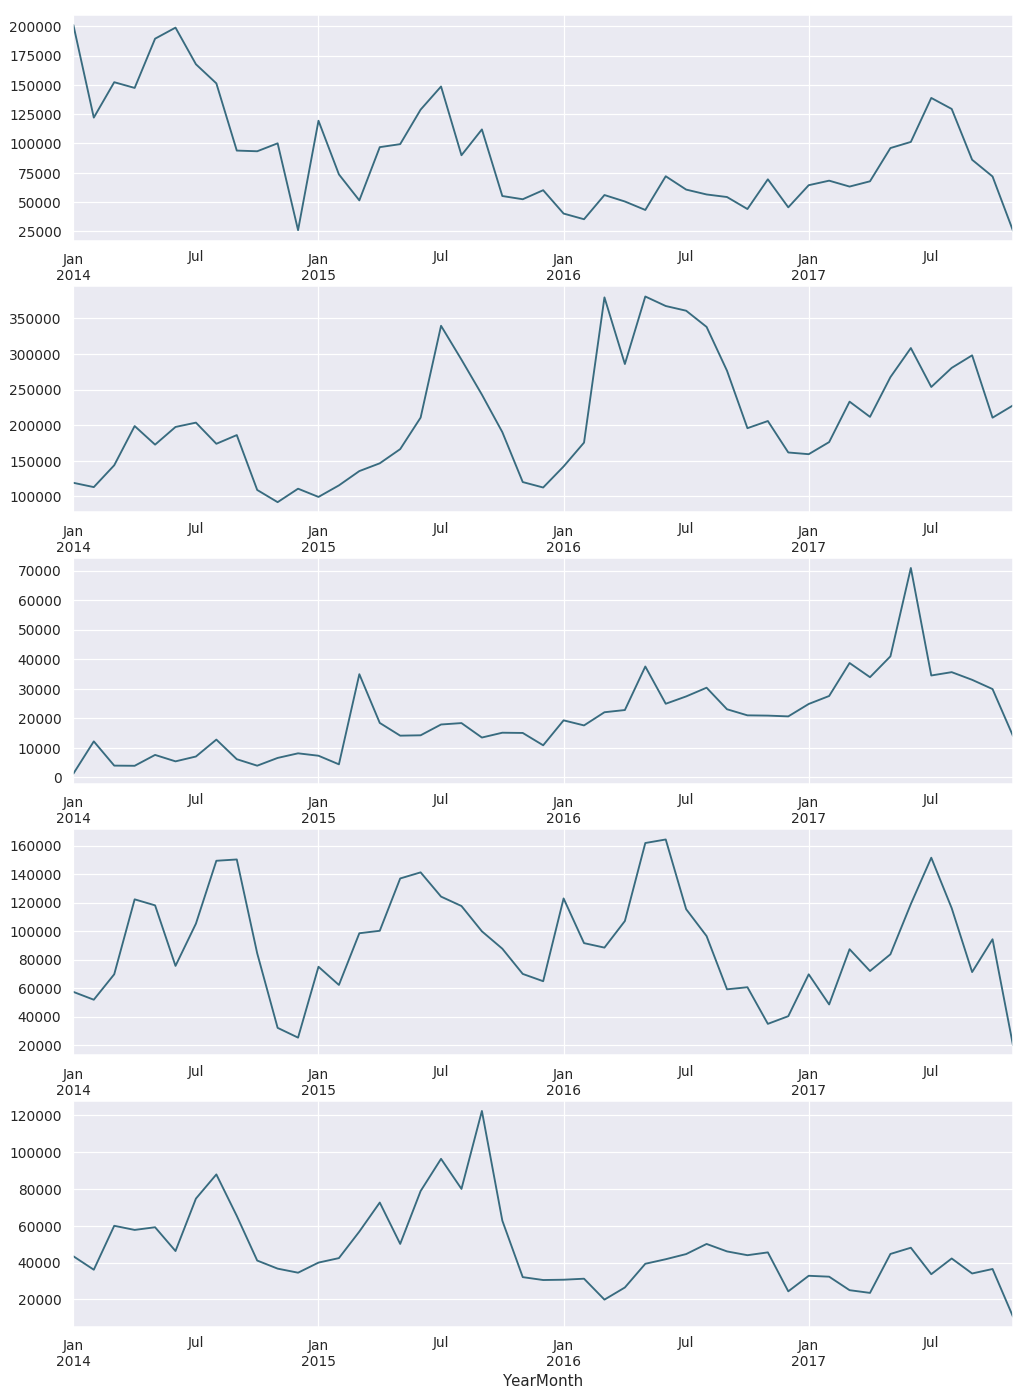

In [18]:
# preparation: input should be float type
train['SalesQty'] = train['SalesQty'] * 1.0

# sales types
sales_1 = train[train.Region == 'East']['SalesQty']
sales_2 = train[train.Region == 'Inner']['SalesQty']
sales_3 = train[train.Region == 'West']['SalesQty']
sales_4 = train[train.Region == 'North']['SalesQty']
sales_5 = train[train.Region == 'South']['SalesQty']

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (12, 18))

# area types
sales_1.resample('M').sum().plot(color = c, ax = ax1)
sales_2.resample('M').sum().plot(color = c, ax = ax2)
sales_3.resample('M').sum().plot(color = c, ax = ax3)
sales_4.resample('M').sum().plot(color = c, ax = ax4)
sales_5.resample('M').sum().plot(color = c, ax = ax5)

<div class = "alert alert-block alert-success"> the sales of each area can see peek are quite diffent during year. for East aear, peek is coming at first year, for West area, peak is coming at 2016, for Inner peak is coming at 2017, for North area, the peak is keeping very good trend, for south area, the peak is coming at first two at 2015  </div>

### Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

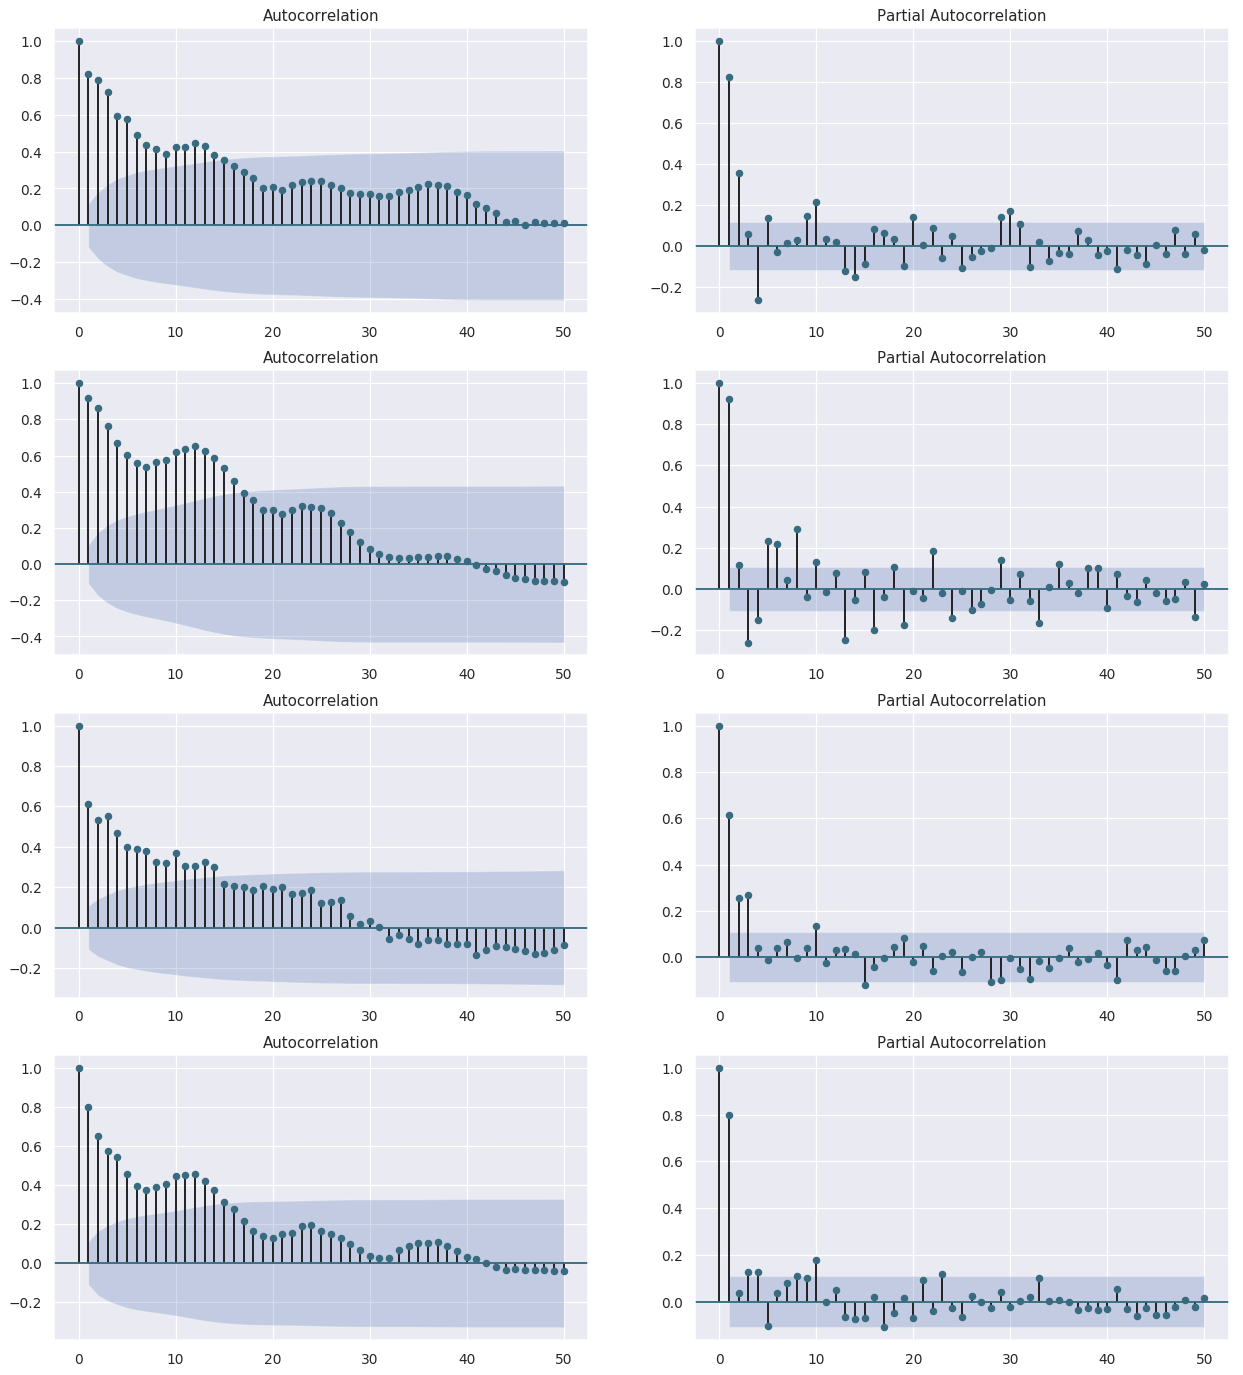

In [19]:
# figure for subplots
plt.figure(figsize = (15, 18))

# acf and pacf for East
plt.subplot(421); plot_acf(sales_1, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_1, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for West
plt.subplot(423); plot_acf(sales_2, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_2, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for Inner
plt.subplot(425); plot_acf(sales_3, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_3, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for North
plt.subplot(427); plot_acf(sales_4, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_4, lags = 50, ax = plt.gca(), color = c)


plt.show()



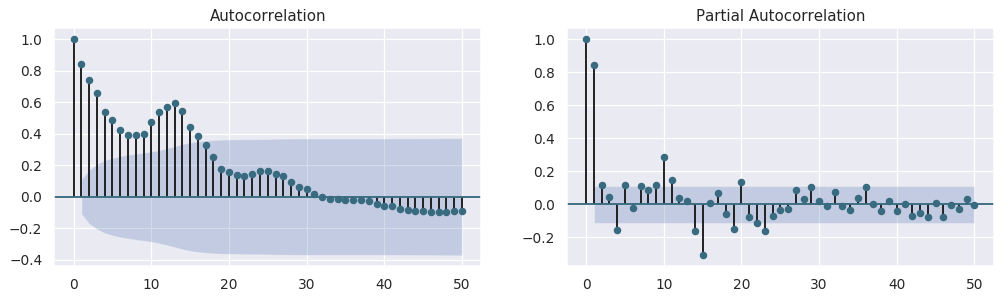

In [20]:
plt.figure(figsize=(12,15))

# acf and pacf for South
plt.subplot(425); plot_acf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'Region', from East to South. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

Falters ACF has trailing characteristics, PACF truncated features, the AR model is more reasonable, if PACF trailing characteristics, ACF has truncated characteristics, the MA model is more reasonable,

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).


## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next month for the first store

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [21]:
# importing data
df = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv",  
                    low_memory = False)


# sales for the area East 
sales = df[df.Region == 'East'].loc[:, ['YearMonth', 'SalesQty']]

# reverse to the order: from 2014 to 2017
sales = sales.sort_index(ascending = False)

# to datetime64
sales['YearMonth'] = pd.DatetimeIndex(sales['YearMonth'])
sales.dtypes

YearMonth    datetime64[ns]
SalesQty            float64
dtype: object

In [22]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'YearMonth': 'ds',
                                'SalesQty': 'y'})
sales.head()

,ds,y
276,2017-11-01,7316.9561
275,2017-10-01,48137.1290
274,2017-09-01,41899.6950
273,2017-08-01,89875.3130
272,2017-07-01,86099.3750


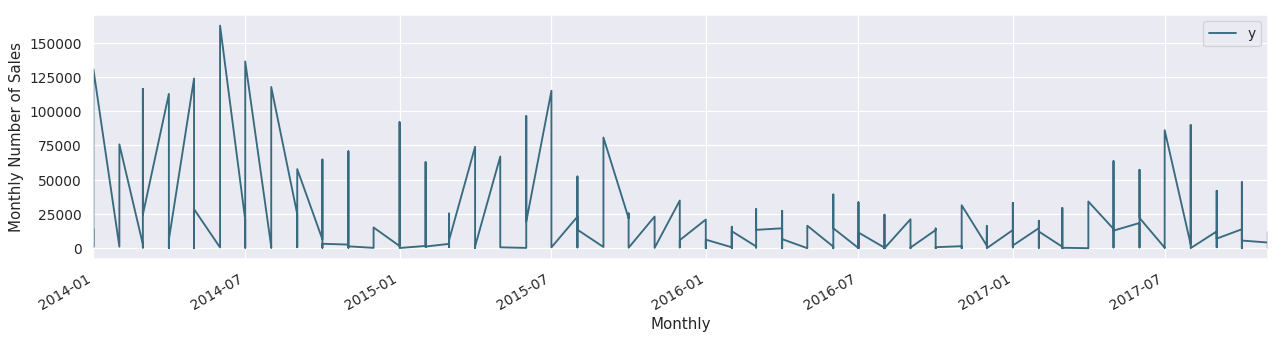

In [23]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (15, 4), color = c)
ax.set_ylabel('Monthly Number of Sales')
ax.set_xlabel('Monthly')
plt.show()

### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [24]:
# create holidays dataframe
state_dates = df[(df.HolidayDay == 1) | (df.HolidayDay == 2) |(df.HolidayDay == 3)|(df.HolidayDay == 4)|(df.HolidayDay == 5)|(df.HolidayDay == 6) |(df.HolidayDay == 7)|(df.HolidayDay == 8)& (df.HolidayDay>0)].loc[:, 'YearMonth'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
holidays = pd.DataFrame(state)
holidays.head(12)

,holiday,ds
0,state_holiday,2014-01-01
1,state_holiday,2014-02-01
2,state_holiday,2014-03-01
3,state_holiday,2014-04-01
4,state_holiday,2014-05-01
5,state_holiday,2014-06-01
6,state_holiday,2014-09-01
7,state_holiday,2014-10-01
8,state_holiday,2015-01-01
9,state_holiday,2015-02-01


In [25]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 1 month 
future_dates = my_model.make_future_dataframe(periods = 120)

print("First month to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First month to forecast.


,ds
390,2018-02-23
391,2018-02-24
392,2018-02-25
393,2018-02-26
394,2018-02-27
395,2018-02-28
396,2018-03-01


In [26]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,-978.009863,-33423.727610,30094.896736
368,2018-02-01,-448.579289,-32714.680521,32862.879556
369,2018-02-02,75.509961,-33165.072974,31070.693497
370,2018-02-03,582.171042,-30693.590375,34549.858961
371,2018-02-04,1060.203804,-26780.450355,32557.401493
372,2018-02-05,1499.568728,-30968.913524,34611.965863
373,2018-02-06,1891.623222,-31795.891392,31895.919782
374,2018-02-07,2229.314471,-27721.562846,33279.478338
375,2018-02-08,2507.324300,-27988.175681,35291.987579
376,2018-02-09,2722.162935,-27561.861447,34704.534472


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [27]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

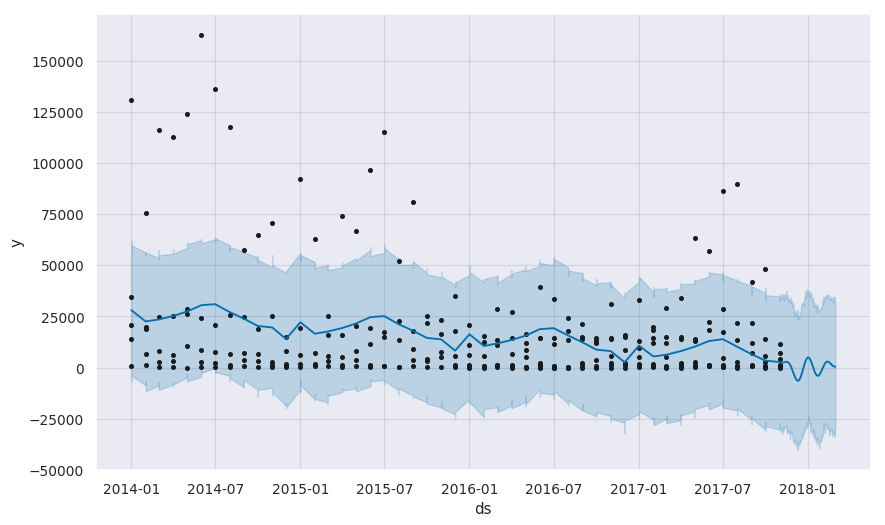

In [28]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

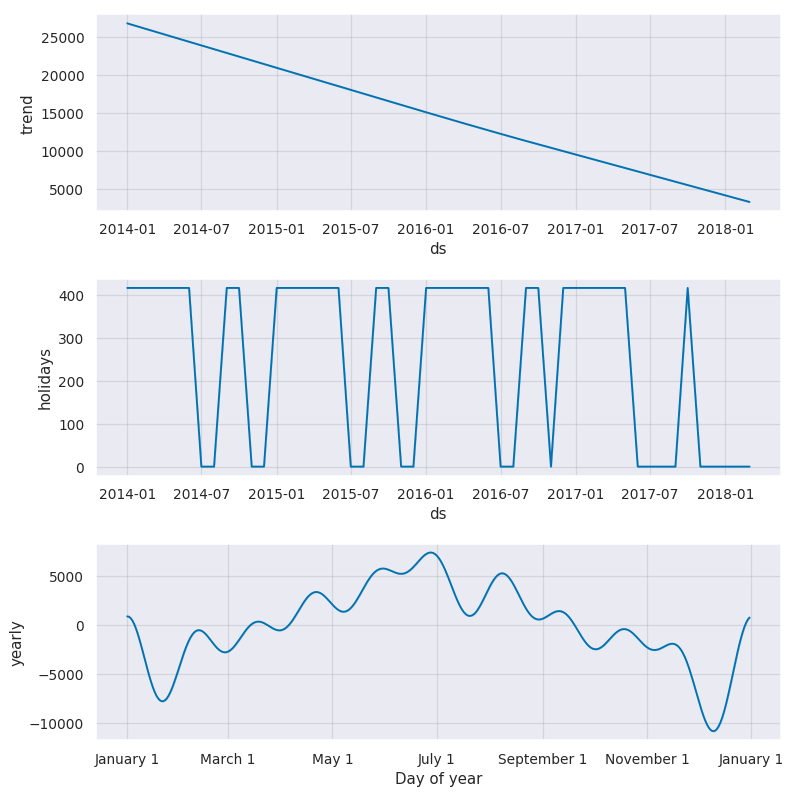

In [29]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the yearly volume of trend.

### Conclusion of Time Series forecasting

During this part we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using a new procedure by Facebook `Prophet`.

We can now present main advantages and drawbacks of time series forecasting:

__Advantages__
- Powerfull tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. Even in our case, we don't have this question, but these variables like `Special` and `CompetitionOpen` or `Special Holiday`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

## Alternative Approach: Regression XGBoost

[XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md) is an implementation of Gradient Boosted Decision trees designed for speed and performance. Its more suitable name is a as [regularized Gradient Boosting](http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/), as it uses a more regularized model formalization to control over-fitting. 

Additional advantages of this algorythm are:

- Automated missing values handling: XGB uses a "learned" default direction for the missing values. "Learned" means learned in the tree construction process by choosing the best direction that optimizes the training loss.
- Interactive feature analysis (yet implemented only in R): plots the structure of decision trees with splits and leaves.
- Feature importance analysis: a sorted barplot of the most significant variables.

<div class = "alert alert-block alert-info"> As we already saw in the previos section our data is higly seasonal and not random (dependent). Therefore, before fitting any models we need to "smooth" target variable Sales. The typical preprocessing step is to log transform the data in question. Once we perform the forecasting we will unwind log transformations in reverse order. </div>

### Quick Run through

In [30]:
from sklearn.model_selection import train_test_split
# to predict to
dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

train,test = train_test_split(dataset,test_size=0.2)

# msk = np.random.rand(len(train)) < 0.8
# train = train[msk]
# test = train[~msk]
print(train.shape)
print(test.shape)

test.head()

(1264, 11)
(316, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2017-11-01,South,6179328252,34,pack1,2318.1770,976.68073,2017,11,4,0,0
2015-12-01,North,6179328252,34,pack1,3447.3640,9212.66700,2015,12,4,0,0
2015-05-01,East,9310070030,33,pack1,13808.1280,66892.97700,2015,5,2,3,1
2015-05-01,West,2111256114,33,pack2,1532.2487,5081.01510,2015,5,2,3,1
2017-05-01,Inner,9310070030,33,pack1,57638.7660,186884.14000,2017,5,2,4,1


Even ETL process has been done, we don't need it anymore, just simply follow the process. 

In [31]:
# test: missing values? just a double check
test.isnull().sum()

Region        0
ItemCode      0
BrandCode     0
Package       0
ShipQty       0
SalesQty      0
Year          0
Month         0
Quarter       0
HolidayDay    0
IsHoliday     0
dtype: int64

In [32]:
test[pd.isnull(test.SalesQty ==0)]

,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,


### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [33]:
# data extraction
# test['Year'] = test.index.year
# test['Month'] = test.index.month
# test['Day'] = test.index.day
# test['WeekOfYear'] = test.index.weekofyear
# to numerical
mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# test.StateHoliday.replace(mappings, inplace = True)
train.Region.replace(mappings, inplace = True) 
train.Package.replace(mappings_pkg, inplace = True)
test.Region.replace(mappings, inplace = True)
test.Package.replace(mappings_pkg, inplace = True)
print(train)
# train_store.Assortment.replace(mappings, inplace = True)
# train_store.StoreType.replace(mappings, inplace = True)
# train_store.StateHoliday.replace(mappings, inplace = True)
# train_store.drop('PromoInterval', axis = 1, inplace = True)
# store.StoreType.replace(mappings, inplace = True)
# store.Assortment.replace(mappings, inplace = True)
# store.drop('PromoInterval', axis = 1, inplace = True)

            Region    ItemCode  BrandCode  Package      ShipQty      SalesQty  \
YearMonth                                                                       
2014-05-01       1  3747832079         34        1   4555.22560    1618.81790   
2017-01-01       4  5763825994         33        0  17713.81100    7490.38570   
2014-07-01       4  5763825994         33        0  13942.74100    9847.24900   
2016-12-01       4  9310070030         33        0   1633.25540   13702.01100   
2014-08-01       3  6179328252         34        0   4951.03960    7691.15090   
2014-06-01       3  3747832079         34        1   5730.64890    2835.50390   
2017-10-01       1  5763825994         33        0   1773.86800    1706.69540   
2015-09-01       2  1698579415         53        0   5127.44480    3575.89480   
2014-07-01       2  5763825994         33        0  26435.53300   36907.84800   
2017-03-01       0  5763825994         33        0   5513.03030   12197.03400   
2015-07-01       1  61793282

Returning back to the `train` data:

### Model Training

#### Approach

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [55]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train.columns if x not in [ 'SalesQty']]
y = np.log(train.SalesQty) # log transformation of Sales
X = train[predictors]
# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)

# y_train[~train([np.nan,np.inf,-np.inf]).any(1)]
print(y_train)

YearMonth
2017-11-01     1.000000
2014-11-01     7.875692
2014-10-01     7.951199
2016-01-01     1.000000
2016-09-01     7.375171
2017-02-01     7.397455
2017-03-01     1.000000
2015-05-01     7.325920
2017-07-01    10.266288
2015-02-01     7.086477
2016-09-01     5.541008
2015-07-01     8.745402
2016-11-01     9.549162
2015-03-01     7.777253
2016-06-01     8.233247
2015-06-01     8.278422
2016-01-01     9.958109
2015-08-01     8.448628
2016-07-01     7.123084
2016-12-01     7.127533
2016-06-01     9.573628
2017-11-01     7.318018
2016-03-01     9.502447
2016-09-01     7.479229
2017-03-01     7.426940
2015-06-01     8.623713
2015-02-01     7.845172
2015-01-01     9.304997
2016-01-01     7.784126
2014-08-01     7.973265
                ...    
2014-07-01     9.194947
2015-06-01    11.527992
2017-10-01     9.457046
2015-02-01     1.000000
2014-01-01     9.042716
2014-11-01     9.579204
2016-07-01     8.956447
2017-02-01     9.904630
2014-03-01    10.723809
2016-03-01     5.755154
2015-1

In [35]:
# predictors
X.columns

Index(['Region', 'ItemCode', 'BrandCode', 'Package', 'ShipQty', 'SalesQty',
       'Year', 'Month', 'Quarter', 'HolidayDay', 'IsHoliday'],
      dtype='object')

In [36]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat / y-1) ** 2))
def rmspe(y, yhat):
    return np.sqrt(np.mean((y-yhat / y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

def metric_RMSPE(y_true, y_predict):
    y1 = np.array(y_predict)
    y2 = np.array(y_true)
    n = len(y_true)
    temp = np.square((y1 - y2)/y2).sum()
    score = np.sqrt(temp/n)
    return score

#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [37]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [38]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.13077	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.46303	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[2]	train-rmse:5.86679	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[3]	train-rmse:5.31719	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[4]	train-rmse:4.83789	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[5]	train-rmse:4.39517	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[6]	train-rmse:3.99489	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[7]	train-rmse:3.64863	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[8]	train-rmse:3.31977	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[9]	train-rmse:3.02167	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[10]	train-rmse:2.75452	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[11]	train-rmse:2.

Last rows:

`
[230]	train-rmse:0.022742	test-rmse:inf	train-rmspe:31154	test-rmspe:35444.8
[231]	train-rmse:0.022351	test-rmse:inf	train-rmspe:31154	test-rmspe:35444.8
[232]	train-rmse:0.022313	test-rmse:inf	train-rmspe:31154	test-rmspe:35444.8
[233]	train-rmse:0.022284	test-rmse:inf	train-rmspe:31154	test-rmspe:35444.8
[234]	train-rmse:0.021807	test-rmse:inf	train-rmspe:31154	test-rmspe:35444.8
[235]	train-rmse:0.021335	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.8
Stopping. Best iteration:
[185]	train-rmse:0.036734	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.8
`

Essentially, we want the least value. The model with base hyperparameters gives out better result on the train set, indicating to the overfitting issue. 

### Grid Search from sklearn

Scikit learn wrapper is famous for the `GridSearchCV` and `RandomizedSearchCV`. Between these two, most of the time the [preference leans towards `RandomnizedSearchCV`](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search), faster version of `GridSearchCV`. 

As an input, `RandomnizedSearchCV` takes only sklearn wrapper of XGboost, so instead of using the first version of a model, we build the analogous model in sklearn with `XGBRegressor`.

In [39]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

For parameters we will specify the regularization parameter `reg_alpha` which reduce model complexity and enhance performance, as well as `gamma` parameter which represents the minimum loss reduction required to make a split and also `max_depth` used to control over-fitting.

In [40]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)
# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

{'gamma': 0.876649899181482, 'learning_rate': 0.2271346996854777, 'max_depth': 14, 'reg_alpha': 3.479483915430011}
0.992354560998594


In [41]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.08106924075327354, 
    'max_depth': 16, 
    'gamma': 2.0946975593149473,
    'reg_alpha': 2.1037132201029216,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 100, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.27757	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:6.72712	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[2]	train-rmse:6.22578	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[3]	train-rmse:5.75574	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[4]	train-rmse:5.33397	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[5]	train-rmse:4.93753	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[6]	train-rmse:4.57444	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[7]	train-rmse:4.25234	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[8]	train-rmse:3.95119	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[9]	train-rmse:3.67424	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[10]	train-rmse:3.42246	test-rmse:inf	train-rmspe:30842.1	test-rmspe:31299.9
[11]	train-rmse:3

[105]	train-rmse:0.767464	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31299.9
[106]	train-rmse:0.767465	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31299.9
[107]	train-rmse:0.764901	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31299.9
[108]	train-rmse:0.764897	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31299.9
[109]	train-rmse:0.764897	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31299.9
[110]	train-rmse:0.763986	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[111]	train-rmse:0.763984	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[112]	train-rmse:0.762109	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[113]	train-rmse:0.760925	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[114]	train-rmse:0.759647	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[115]	train-rmse:0.758708	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[116]	train-rmse:0.758708	test-rmse:inf	train-rmspe:30841.8	test-rmspe:31300
[117]	train-rmse:0.758708	test-rmse:inf	train-rmspe:30841.8	test-r

Last five rows:
    
`
[281]	train-rmse:0.714217	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[282]	train-rmse:0.714218	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[283]	train-rmse:0.714218	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[284]	train-rmse:0.714217	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[285]	train-rmse:0.714221	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[286]	train-rmse:0.713675	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[287]	train-rmse:0.713338	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
[288]	train-rmse:0.713338	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
Stopping. Best iteration:
[188]	train-rmse:0.729369	test-rmse:inf	train-rmspe:31154.1	test-rmspe:35444.9
`

We resolved an issue with overfitting, but due to the decrease of learning rate (`eta`) we got a bit worse overall score on the test set (~0.11 to ~0.14).

In [42]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))


error = rmspe(X_test.SalesQty.values, np.exp(yhat))
print('First validation yelds RMSPE: {:.6f}'.format(error))


First validation yelds RMSPE: inf


Even though we observed a bit higher RMSPE value, we need to remember that the corresponding `eta` for the first version was 0.1, which is usually considered as high. I think that it's remarkable that we got more or less the same result but with 2x lower `eta` (0.1 to 0.04).

__Next steps towards model's improvement will involve further decrease of `eta`, tuning of correpsonding `gamma` and `max_depth`.__

### Model understanding

Feature importance scores help us see which variables contributed the most to the score.

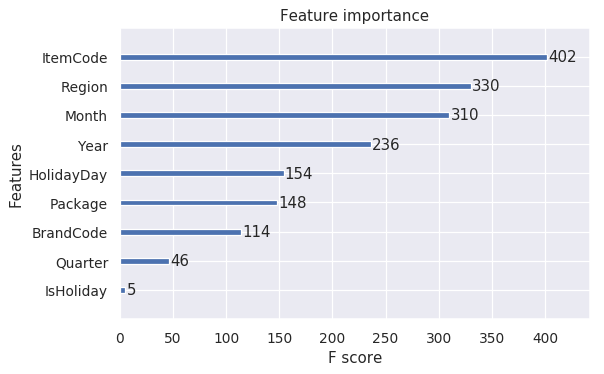

In [43]:
xgb.plot_importance(model_final)

Variables `ItemCode` and `Month` are both leading. Then go features `Region`,  `Year`, `HolidayDay`, `Package` ,`BrandCode`,`Quarter`,and deducted features `IsHoliday`.

### Prediction to unseen data

In [44]:
from sklearn.model_selection import train_test_split
# to predict to
dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

train,test = train_test_split(dataset,test_size=0.2)
# predictions to unseen data

mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}
test.Region.replace(mappings, inplace = True)
test.Package.replace(mappings_pkg, inplace = True)
unseen = xgb.DMatrix(test[predictors])
test_p = model_final.predict(unseen)
forecasts = pd.DataFrame({'ShipQty': test['ShipQty'], 
                          'SalesQty': np.exp(test_p)})
# forecasts
forecasts.head()

,ShipQty,SalesQty
YearMonth,,
2014-10-01,2757.2090,2598.934570
2014-10-01,2479.2383,2699.403076
2016-06-01,9524.1543,9915.313477
2017-06-01,1411.5442,2951.403320
2014-02-01,10352.0430,7254.294922


## Alternative another approach of LSTM 

In [45]:
import os 
import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Flatten, TimeDistributed,RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from pandas import HDFStore
import numpy as np 



Using TensorFlow backend.


## Feature Engineering

In [46]:
# dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')

# train,test = train_test_split(dataset,test_size=0.2)

# mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# # test.StateHoliday.replace(mappings, inplace = True)
# train.Region.replace(mappings, inplace = True) 
# train.Package.replace(mappings_pkg, inplace = True)
# test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
# print(train)
def normarlize():
    train_norm = train.apply(lambda x: (x-np.mean(x)/(np.max(x) - np.min(x))))
    return train_norm 


def shuffle(X,Y):
    np.random.seed(20)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(units = 1,  activation = 'relu', input_shape =(1,11)))
#     model.add(Flatten())
    model.add(Dense(1))
    model.add(Dropout(0.5))
    model.compile(loss="mse",optimizer="adam")
    
    model.summary()
    return model


### splite data & training 

In [87]:
predictors = [x for x in train.columns if x not in [ 'SalesQty',]]
y = np.log(train.SalesQty) # log transformation of Sales
X = train[predictors]
# print(X)
# print('===========================')
# print(y_train)
# print('==============================')
# print(y_train.shape)
# # split the data into train/test set


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
X_train.Region.replace(mappings, inplace = True) 
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)

X_train_array = X_train.iloc[:,:]
X_test_array =  X_test.iloc[:,:]
y_train_array = y_train.iloc[:]
y_test_array =  y_test.iloc[:]

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

X_train, y_train = X_train_array[:], y_train_array[:]
#X_val, y_val = val_set_scaled[:,:-1], val_set_scaled[:,-1]
X_test, y_test = X_test_array[:], y_test_array[:]


print("====================")
# print(y_train)
print("====================")
# print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)
print('===========================')
# print(X_train)
# print(X_train.shape[1])
# y_train.replace(-np.inf,1)
# y_train.fillna(0,inplace=True)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# X_train = X_train.


# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# test.StateHoliday.replace(mappings, inplace = True)
# train.Package.replace(mappings_pkg, inplace = True)
# X_test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
# input_X_train = np.concatenate((input_X_train,))
# input_X_train=input_X_train.reshape(input_X_train,(input_X_train.shape[0],1,input_X_train.shape[1]))

X_train = X_train.values
print(X_train)

X_train = X_train.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
model = buildManyToOneModel(X_train.shape)
print('=====================================')
# print(X_train)
# print(X_train.values)

# 
# X_train = np.reshape(X_train,(-1,1, X_train.shape[1]))
# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
model.fit(X_train, y_train, epochs=100, batch_size= 884, verbose=1)


AttributeError: 'numpy.ndarray' object has no attribute 'describe'

---

## Final thoughts

Time Series Analysis is a must for time series data. It goes much deeper than ad-hoc Exploratory Data Analysis, revealing trends, non randomness of the data and seasonalities.

I was particularly excited to use a new forecasting procedure Prophet. Eventhough this tool is still under development, it has everything set for the advanced modeling as it can account for change points in trends and holidays in the data. In the meantime, the most sophisticated tool for the Time Series Analysis stays auto.arima from R forecast package.

A significant jump in the forecasting performance of the model fitted above, XGboost with xgboost library, can be achieved by increasing the number and range of hyperparameters. Due to the number of observations (800k) and with a laptop like mine, the "more developped" grid search would take about 2-3 days to fit. So I left this room for the improvement for later notebooks.

Another method that I didn't cover here is a regression model Stacking, which works great for small or medium size data sets. We would basically combine XGboost, RandomForest, NN and SVM for regression. And then stack them together by building the final model.